# Map picking trends

In [1]:
from s2_analytics.filters import PLAYLIST_CTF
import os

import pandas as pd
import seaborn as sns
from IPython.core.display import Markdown
from pandas import DataFrame

from s2_analytics.collector.sqlite_collector import SqliteCollector
from s2_analytics.importer import import_games


def dump_csv(df: DataFrame, id: str):
    csv_path = f"data/{id}.csv"
    csv_abs_path = f"{os.getcwd()}/build/markdown/{csv_path}"
    df.to_csv(csv_abs_path)
    display(Markdown(f"Chart data: [csv]({csv_path})"))


sqlite_collector = SqliteCollector("file::memory:").init()
import_games("logs_ranked/", period_days=43,
             processors=[sqlite_collector], game_filters=[PLAYLIST_CTF])
con = sqlite_collector.connection
cur = con.cursor()
cur.execute("""
create table map_picks_by_date as
    select distinct comb.date,
                comb.mapName,
                sum(iif(r.game is null, 0, 1)) rounds_played -- count only if not null
                -- all date+map combinations
    from (select *
      from (select distinct dates.date from round dates)
               cross join (select distinct mapName from round maps)) comb
         left outer join round r on r.date = comb.date and r.mapName = comb.mapName
    group by comb.date, comb.mapName
""")
pass

## Data summary

In [2]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query, con)

,first_game_start_time,last_game_start_time,games_count
0,2022-12-19 21:36:45,2023-01-30 21:50:19,508


In [3]:
query = """
select
    playlistCode,
    count(1) games_count
from game group by playlistCode
"""
pd.read_sql_query(query, con)

,playlistCode,games_count
0,CTF-Standard-4,18
1,CTF-Standard-6,488
2,CTF-Standard-8,2


## Map picking trends

Chart data: [csv](data/map-trends-a-g-14-days-avg.csv)

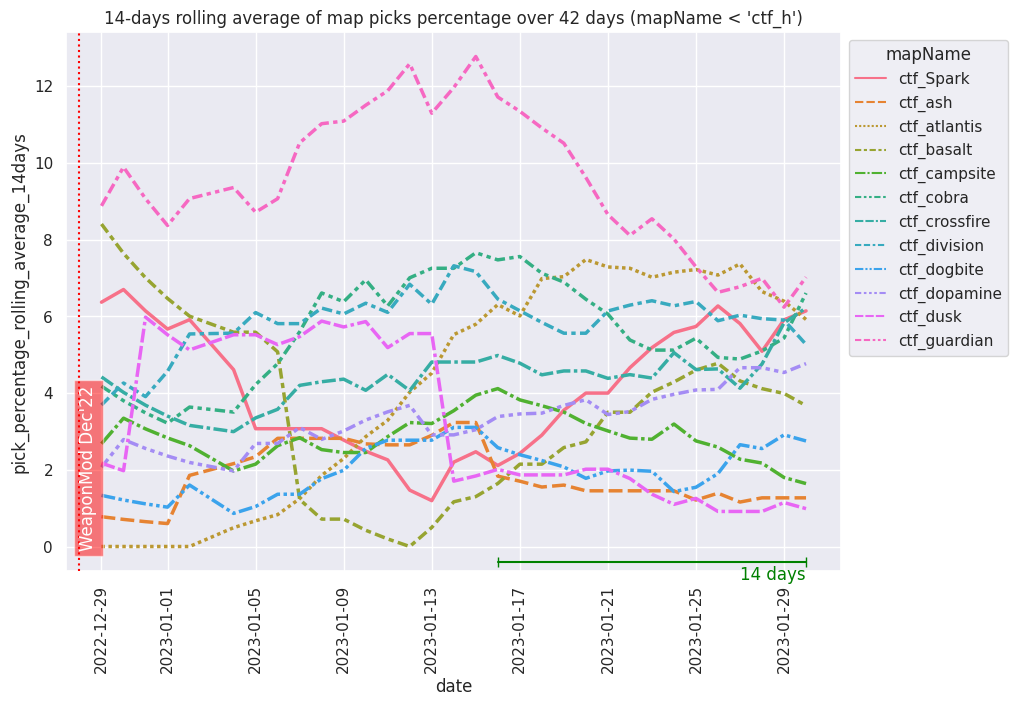

In [4]:
from datetime import timedelta
from matplotlib.lines import Line2D
from s2_analytics.constants import WEAPON_MODS_DATES
from matplotlib.ticker import FixedLocator


def rolling_average_map_pick(condition, id, days, height=10):
    total_period = days * 3
    df = pd.read_sql_query(f"""
    select
        mapName,
        date,
        100.0 * rounds_played / (select sum(rounds_played) from map_picks_by_date mpd2 where mpd.date = mpd2.date) as pick_percentage
    from map_picks_by_date mpd
        where {condition}
        and date >= datetime('now', '-{total_period} days')
    """, con, parse_dates=['date'])

    def generate_rolling_average_plot(df, days):
        groupby = df.groupby("mapName", as_index=False, group_keys=False)
        df[f"pick_percentage_rolling_average_{days}days"] = groupby.apply(
            lambda grp, freq: grp.rolling(freq, on='date', min_periods=int(0.75 * days))['pick_percentage'].mean(),
            f"{days}D")
        sns.set(rc={'figure.figsize': (10, height)})
        plt = sns.lineplot(df, x="date", y=f"pick_percentage_rolling_average_{days}days", style="mapName",
                           hue="mapName", linewidth=2.5)
        plt.xaxis.set_major_locator(FixedLocator(plt.get_xticks().tolist()))
        plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
        plt.set_title(f"{days}-days rolling average of map picks percentage over {total_period} days ({condition})")
        sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))
        # weaponmod marker
        chart_start_date = df["date"].min()
        if chart_start_date < WEAPON_MODS_DATES[-1]:
            for date in WEAPON_MODS_DATES:
                if date > chart_start_date:
                    plt.axvline(date, color="red", linestyle="dotted", zorder=3)
                    plt.text(date, 0, 'WeaponMod ' + date.date().strftime("%b'%y"), rotation=90, color="white",
                             bbox = dict(facecolor = 'red', alpha = 0.5), zorder=3)

        # average period marker
        max_date = df["date"].max()
        plt.add_line(Line2D([max_date - timedelta(days=days), max_date], [-0.4, -0.4], color="green", zorder=3, marker="|", markersize=7))
        plt.text(max_date, -0.5, f"{days} days", color="green", ha="right", va="top", zorder=3)

        return plt, df

    dump_csv(df, f"map-trends-{id}-{days}-days-avg")
    generate_rolling_average_plot(df, days)


rolling_average_map_pick("mapName < 'ctf_h'", "a-g", 14, height=7)
pass

Chart data: [csv](data/map-trends-h-z-14-days-avg.csv)

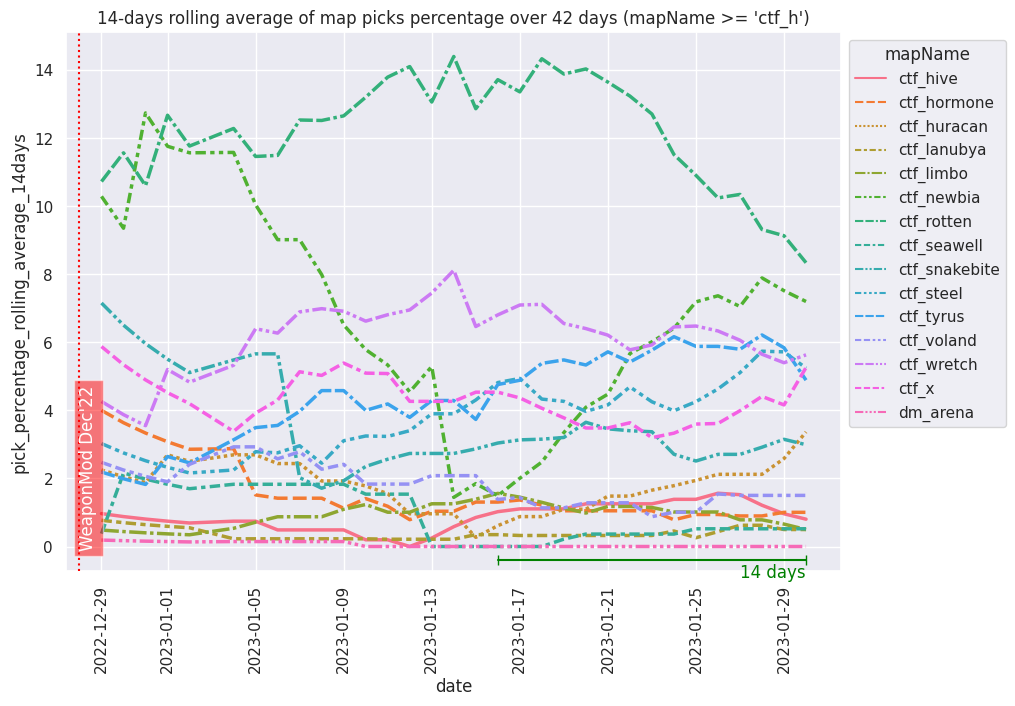

In [5]:
rolling_average_map_pick("mapName >= 'ctf_h'", "h-z", 14, height=7)
pass

# yeah apparently someone managed to play ctf on dm_arena in game 1672178428906

## Maps not played in last 7 days

In [6]:
pd.read_sql_query(f"""
    select * from
        (select
            mapName,
            max(date) last_played
        from round
        group by mapName)
    where last_played < datetime('now', '-7 day')
    order by last_played desc
    """, con)

,mapName,last_played
0,dm_arena,2022-12-27
